In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
import backtrader as bt
import pyfolio as pf

### Parameters

In [3]:
ticker = 'AAPL'
days=[5, 20]
return_days = 5
extreme = 3
test_date_start = datetime(2013,1,1)
test_date = test_date_start.strftime('%Y-%m-%d')
test_date_end = datetime(2017,1,1)
filename = '{}_{}_{}.h5py'.format(ticker, return_days, extreme)

In [4]:
aal = pdr.get_data_google(ticker, '2000-01-01', '2017-01-01')

In [5]:
aal.drop('Volume', axis=1, inplace=True)
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-06,1.44,1.53,1.43,1.51
2001-02-07,1.48,1.49,1.42,1.48
2001-02-08,1.47,1.50,1.44,1.48
2001-02-09,1.46,1.49,1.33,1.37
2001-02-12,1.36,1.43,1.34,1.41


In [6]:
def _set_index_column_if_necessary(data: pd.DataFrame) -> pd.DataFrame:
    if 'Date' in data.columns:
        data.set_index('Date', inplace=True)
    return data

In [7]:
aal = _set_index_column_if_necessary(aal)
cols = aal.columns
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-06,1.44,1.53,1.43,1.51
2001-02-07,1.48,1.49,1.42,1.48
2001-02-08,1.47,1.50,1.44,1.48
2001-02-09,1.46,1.49,1.33,1.37
2001-02-12,1.36,1.43,1.34,1.41


In [8]:
cols

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
def feature(data, first_col, second_col):
    return data[first_col]/data[second_col]

In [10]:
def create_extra_columns(data, cols):
    pool = []
    for left, right in itertools.product(cols, cols):
        pair1 = left + right
        pair2 = right + left
        if left != right and pair1 not in pool and pair2 not in pool:
            aal[left + '/' + right] = feature(data, left, right)
            pool.append(pair1)

### Rolling features

In [11]:
for col, day in itertools.product(cols, days):
    aal[col + ' ' + str(day) + ' MA'] = aal[col].rolling(day).mean()
    aal[col + ' ' + str(day) + ' max'] = aal[col].rolling(day).max()
    aal[col + ' ' + str(day) + ' min'] = aal[col].rolling(day).min()
aal.dropna(inplace=True)

In [12]:
aal.columns

Index(['Open', 'High', 'Low', 'Close', 'Open 5 MA', 'Open 5 max', 'Open 5 min',
       'Open 20 MA', 'Open 20 max', 'Open 20 min', 'High 5 MA', 'High 5 max',
       'High 5 min', 'High 20 MA', 'High 20 max', 'High 20 min', 'Low 5 MA',
       'Low 5 max', 'Low 5 min', 'Low 20 MA', 'Low 20 max', 'Low 20 min',
       'Close 5 MA', 'Close 5 max', 'Close 5 min', 'Close 20 MA',
       'Close 20 max', 'Close 20 min'],
      dtype='object')

In [13]:
plain_features = list(filter(lambda col: '/' not in col, aal.columns))

In [14]:
create_extra_columns(aal, plain_features)

In [15]:
ret = 100*aal['Close'].pct_change(return_days).shift(-return_days)

In [16]:
# ret_dev = ret.rolling(10).std().fillna(1)

# ret_scaled = ret/ret_dev
# ret_scaled.head()

In [17]:
features_to_drop = list(filter(lambda col: '/' not in col, aal.columns))
aal.drop(features_to_drop, axis=1, inplace=True)

aal['Return'] = ret # ret_scaled
aal.head(10)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min,Return
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-06,0.936709,1.000000,0.961039,1.085044,1.000000,1.165354,1.068978,1.000000,1.165354,1.023513,...,1.102757,1.000000,1.184615,0.930899,0.844156,1.000000,0.906818,1.074231,1.184615,-9.090909
2001-03-07,0.987013,1.027027,1.000000,1.091954,1.000000,1.196850,1.094707,1.000000,1.196850,1.029810,...,1.102362,1.000000,1.184615,0.959198,0.870130,1.030769,0.907143,1.074615,1.184615,-3.947368
2001-03-08,0.980132,1.013699,0.993289,1.032078,0.973684,1.129771,1.065898,0.973684,1.165354,0.980132,...,1.101968,1.000000,1.184615,0.987478,0.896104,1.061538,0.907468,1.075000,1.184615,-5.369128
2001-03-09,0.993243,1.027972,1.013793,1.002729,0.967105,1.065217,1.058696,0.967105,1.157480,0.970938,...,1.103152,1.000000,1.184615,1.038682,0.941558,1.115385,0.906494,1.073846,1.184615,-3.448276
2001-03-12,0.992958,1.093023,1.060150,0.957880,0.927632,1.000000,1.017316,0.927632,1.110236,0.936255,...,1.104735,1.000000,1.184615,0.954089,0.863636,1.023077,0.905195,1.072308,1.184615,10.526316
2001-03-13,0.964286,1.038462,0.964286,0.933610,0.888158,1.000000,0.974377,0.888158,1.062992,0.918367,...,1.090779,0.987013,1.169231,0.954431,0.863636,1.023077,0.904870,1.071923,1.184615,0.714286
2001-03-14,0.904110,1.000000,0.904110,0.938834,0.891892,1.000000,0.956175,0.868421,1.039370,0.907840,...,1.065808,0.967532,1.146154,0.951359,0.863636,1.023077,0.907792,1.075385,1.184615,-1.369863
2001-03-15,0.973856,1.087591,1.056738,1.058239,1.000000,1.128788,1.074648,0.980263,1.173228,1.021948,...,1.043603,0.948052,1.123077,0.950679,0.863636,1.023077,0.908442,1.076154,1.184615,9.219858
2001-03-16,0.931034,1.000000,0.964286,0.975434,0.906040,1.022727,0.975786,0.888158,1.062992,0.929752,...,1.044723,0.948052,1.123077,0.951699,0.863636,1.023077,0.907468,1.075000,1.184615,17.142857


In [18]:
len(aal.columns)

379

In [19]:
list(aal.columns)[:5]

['Open/High', 'Open/Low', 'Open/Close', 'Open/Open 5 MA', 'Open/Open 5 max']

# X/y spit

In [20]:
aal.dropna(inplace=True)
aal.replace([np.inf, -np.inf], 1, inplace=True)
X_data = aal.drop('Return', axis=1)
y_data = aal['Return']

In [21]:
X_data.head(2)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 5 min,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-06,0.936709,1.000000,0.961039,1.085044,1.0,1.165354,1.068978,1.0,1.165354,1.023513,...,1.184615,1.102757,1.0,1.184615,0.930899,0.844156,1.000000,0.906818,1.074231,1.184615
2001-03-07,0.987013,1.027027,1.000000,1.091954,1.0,1.196850,1.094707,1.0,1.196850,1.029810,...,1.149254,1.102362,1.0,1.184615,0.959198,0.870130,1.030769,0.907143,1.074615,1.184615


In [22]:
y_data.head(2)

Date
2001-03-06   -9.090909
2001-03-07   -3.947368
Name: Return, dtype: float64

In [23]:
def series_to_binarized_columns(y):
    pos = y > extreme
    neg = y < -extreme
    meds = (y > -extreme) & (y < extreme)
    y = np.array([neg, meds, pos]).T
    return y

In [24]:
X_train = X_data[:test_date]
X_test = X_data[test_date:]
y_train = y_data[:test_date]
y_test = y_data[test_date:]

In [25]:
y_train = series_to_binarized_columns(y_train)
y_test = series_to_binarized_columns(y_test)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [27]:
X_test_df = X_test.copy()
X_test = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns, index=X_test_df.index)

In [28]:
X_test_df.head(1)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 5 min,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.873237,0.314282,0.393738,2.177864,0.780632,1.6461,0.46565,0.080512,-0.037041,2.398973,...,0.652566,-0.016756,-0.311992,-0.543325,-0.447536,-0.611417,-0.951099,-0.442306,-0.852867,-0.296829


# KERAS

In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

In [31]:
def expand(X, axis=1):
    return np.expand_dims(X, axis=axis)

In [32]:
temp_y = np.argmax(y_train, axis=1)
cw = class_weight.compute_class_weight('balanced', np.unique(temp_y), temp_y)
cw

array([ 1.49246988,  0.73570898,  1.03014553])

In [33]:
input_shape = (1, 1, X_train.shape[1])
input_shape

(1, 1, 378)

In [34]:
def build_and_run():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, batch_input_shape=input_shape, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='glorot_uniform'))
    model.add(Activation('softmax'))

    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    for i in range(30):
        print(f'Iteration {i}')
        model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=5, shuffle=False, verbose=2)
        model.reset_states()
    model.save(filename)
    return model

In [35]:
#model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=100, shuffle=False, verbose=2) # , validation_data=(expand(X_test), y_test)

In [36]:
try:
    model = load_model(filename)
except:
    model = build_and_run()

Iteration 0
Epoch 1/5
 - 13s - loss: 1.0881 - acc: 0.4268
Epoch 2/5
 - 11s - loss: 1.0619 - acc: 0.4356
Epoch 3/5
 - 12s - loss: 1.0600 - acc: 0.4427
Epoch 4/5
 - 12s - loss: 1.0552 - acc: 0.4538
Epoch 5/5
 - 13s - loss: 1.0500 - acc: 0.4511
Iteration 1
Epoch 1/5
 - 13s - loss: 1.0453 - acc: 0.4524
Epoch 2/5
 - 12s - loss: 1.0394 - acc: 0.4564
Epoch 3/5
 - 12s - loss: 1.0336 - acc: 0.4628
Epoch 4/5
 - 12s - loss: 1.0325 - acc: 0.4605
Epoch 5/5
 - 12s - loss: 1.0128 - acc: 0.4760
Iteration 2
Epoch 1/5
 - 12s - loss: 1.0139 - acc: 0.4746
Epoch 2/5
 - 12s - loss: 1.0087 - acc: 0.4797
Epoch 3/5
 - 12s - loss: 1.0037 - acc: 0.4780
Epoch 4/5
 - 13s - loss: 1.0181 - acc: 0.4790
Epoch 5/5
 - 13s - loss: 1.0021 - acc: 0.4860
Iteration 3
Epoch 1/5
 - 14s - loss: 0.9924 - acc: 0.4948
Epoch 2/5
 - 13s - loss: 0.9933 - acc: 0.4914
Epoch 3/5
 - 12s - loss: 0.9825 - acc: 0.5133
Epoch 4/5
 - 13s - loss: 0.9677 - acc: 0.5180
Epoch 5/5
 - 12s - loss: 0.9692 - acc: 0.5119
Iteration 4
Epoch 1/5
 - 12s - l

In [37]:
class ModelEvaluator:
    def __init__(self,
                 model):
        self.model = model

    def evaluate(self, X, y, ret):
        all_returns = []
        for c in [0.34 + x/50 for x in range(35)]:
            print('=================')
            print(f'Certainty is {c}')
            returns = self.calculate_returns(X, y, ret, c)
            cont = self.print_returns_distribution(returns)
            if not cont:
                break

    def calculate_returns(self, X, y, ret, certainty):
        predicted = self.model.predict(expand(X), batch_size=1)
        real_ups = y[:, 2]
        real_downs = y[:, 0]
        predicted_ups = (predicted[:, 2] > certainty)# & (np.argmax(predicted, axis=1) == 2)
        predicted_downs = (predicted[:, 0] > certainty)# & (np.argmax(predicted, axis=1) == 0)
        returns = np.append(ret[predicted_ups],
                            (-1 * ret[predicted_downs]))

        print('Real ups count: {}'.format(pd.value_counts(real_ups[predicted_ups])))
        print('Real downs count: {}'.format(pd.value_counts(real_downs[predicted_downs])))
        return returns

    def print_returns_distribution(self, returns):
        lose = np.sum(returns[returns < 0])
        win = np.sum(returns[returns > 0])
        if lose == 0 and win == 0:
            return False
        print('Negative returns:', str(lose))
        print('Positive returns:', str(win))
        print('Pos/Neg ratio:', str(win / (lose * -1)))
        print('Sum of returns:', str(np.sum(returns)))
        return True

In [38]:
evaluator = ModelEvaluator(model)
evaluator.evaluate(X_test, y_test, y_data[test_date:]) # [:988]

Certainty is 0.34
Real ups count: False    327
True     104
dtype: int64
Real downs count: False    148
True      43
dtype: int64
Negative returns: -760.513452301
Positive returns: 995.714249615
Pos/Neg ratio: 1.30926579484
Sum of returns: 235.200797314
Certainty is 0.36000000000000004
Real ups count: False    301
True      92
dtype: int64
Real downs count: False    136
True      31
dtype: int64
Negative returns: -698.949110439
Positive returns: 839.499181134
Pos/Neg ratio: 1.20108770237
Sum of returns: 140.550070695
Certainty is 0.38
Real ups count: False    267
True      80
dtype: int64
Real downs count: False    116
True      28
dtype: int64
Negative returns: -636.206144854
Positive returns: 729.85868916
Pos/Neg ratio: 1.14720471511
Sum of returns: 93.6525443062
Certainty is 0.4
Real ups count: False    243
True      68
dtype: int64
Real downs count: False    96
True     23
dtype: int64
Negative returns: -532.620999847
Positive returns: 618.315780741
Pos/Neg ratio: 1.16089260641
Sum

# Backtest

In [72]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.certainty = 0.34
        self.dataclose = self.datas[0].close
        self.orders = {}
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
    def entries_to_remove(entries, the_dict):
        for key in entries:
            if key in the_dict:
                del the_dict[key]

    def next(self):
        if not self.position:
            try:
                today = self.datas[0].datetime.date(0).isoformat()
                data_row = X_test_df.loc[today]
                prediction = model.predict(expand(expand(data_row,0),0))[0]
                def log_candles():
                    self.log('Current Open: {}, Close: {}'.format(self.data0.open[0],self.data0.close[0]))
                    self.log('Next Open: {}, Close: {}'.format(self.data0.open[1],self.data0.close[1]))
                
                if prediction[2] > self.certainty:
                    self.log(f'======> Predict long for {today}')
                    log_candles()
                    self.orders[len(self)] = self.buy(exectype=bt.Order.Market)
                elif prediction[0] > self.certainty:
                    self.log(f'======> Predict short for {today}')
                    log_candles()
                    self.orders[len(self)] = self.sell(exectype=bt.Order.Market)
            except Exception as e:
                self.log(e)
        
        old_entries = []
        for days, order_on_days in self.orders.items():
            if len(self) >= days + return_days:
                old_entries.append(days)
                if order_on_days.isbuy():
                    self.log('closing the long position')
                    self.sell(exectype=bt.Order.Market)
                else:
                    self.log('closing the short position')
                    self.buy(exectype=bt.Order.Market) # exectype=bt.Order.Close
        TestStrategy.entries_to_remove(old_entries, self.orders)

In [73]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname=ticker,
    fromdate=test_date_start,
    todate=test_date_end,
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2013-01-02, ======> Predict long for 2013-01-02
2013-01-02, Current Open: 79.12, Close: 70.93
2013-01-02, Next Open: 78.27, Close: 70.04
2013-01-03, BUY EXECUTED, 70.93
2013-01-09, closing the long position
2013-01-10, SELL EXECUTED, 66.81
2013-01-10, ======> Predict long for 2013-01-10
2013-01-10, Current Open: 75.51, Close: 67.64
2013-01-10, Next Open: 74.43, Close: 67.22
2013-01-11, BUY EXECUTED, 67.64
2013-01-17, closing the long position
2013-01-18, SELL EXECUTED, 64.95
2013-01-18, ======> Predict short for 2013-01-18
2013-01-18, Current Open: 71.22, Close: 64.6
2013-01-18, Next Open: 72.08, Close: 65.22
2013-01-22, SELL EXECUTED, 64.60
2013-01-28, closing the short position
2013-01-29, BUY EXECUTED, 58.12
2013-01-29, ======> Predict long for 2013-01-29
2013-01-29, Current Open: 65.5, Close: 59.21
2013-01-29, Next Open: 65.29, Close: 59.02
2013-01-30, BUY EXECUTED, 59.21
2013-02-05, closing the long position
2013-02-06, SELL EXECUTED, 59.15
2013

Entire data start date: 2013-01-02
Entire data end date: 2016-12-30
Backtest months: 48


,Backtest
Annual return,-3.5%
Cumulative returns,-13.2%
Annual volatility,10.9%
Sharpe ratio,-0.27
Calmar ratio,-0.13
Stability,0.11
Max drawdown,-25.8%
Omega ratio,0.94
Sortino ratio,-0.39
Skew,0.75


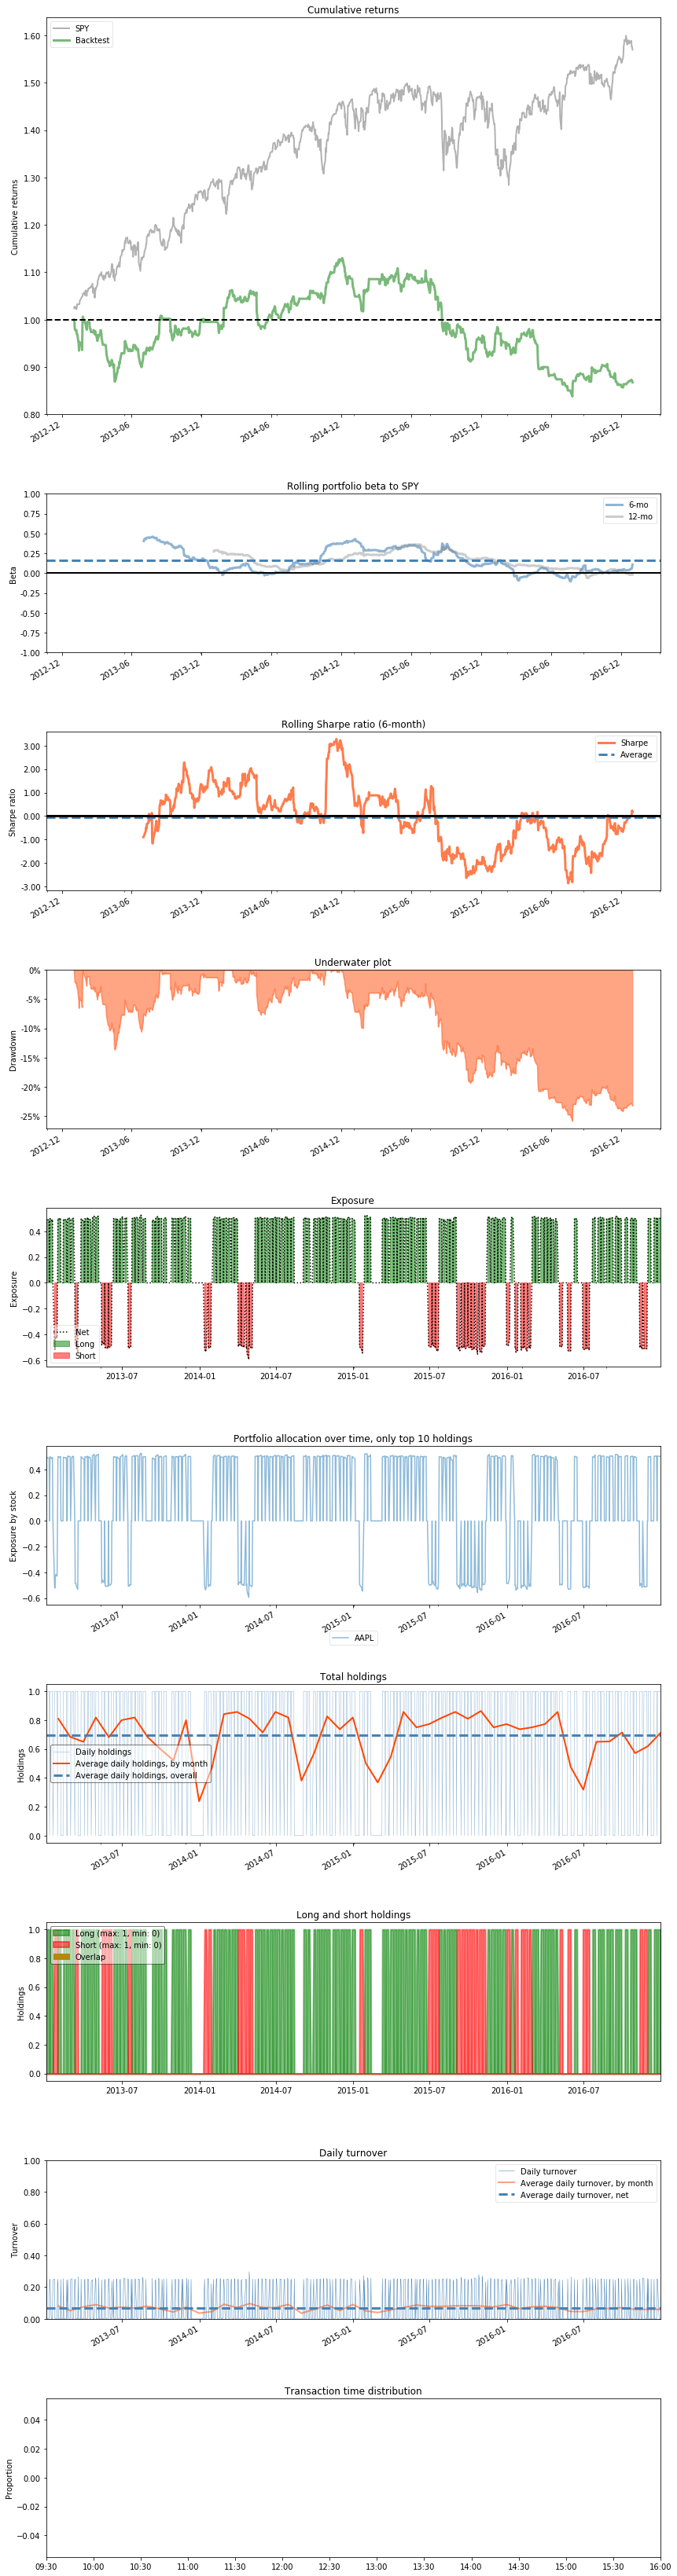

In [74]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)